<a href="https://colab.research.google.com/github/nocturnalrrx/portfolio/blob/main/task_1/task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возьмем открытый датасет в Bigquery - https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ga4_obfuscated_sample_ecommerce&t=events_20210131&page=table

Напишем запрос для построения воронки закрытого типа со следующими шагами:  select_item, view_item, add_to_cart, purchase:

In [11]:
from google.colab import auth
from google.cloud import bigquery
from IPython.display import IFrame, display

%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
%%bigquery --project halogen-rampart-352207
with base as (
  select
  user_pseudo_id
  , event_name
  , event_timestamp
  , lead (event_name, 1) over (partition by user_pseudo_id order by event_timestamp) as next_event
  from `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210131`
  where event_name in ('select_item', 'view_item', 'add_to_cart', 'purchase')
  order by user_pseudo_id, event_timestamp
),

events as (
  select
  user_pseudo_id
  , event_name as event_1
  , lead (event_name, 1) over (partition by user_pseudo_id order by event_timestamp) as event_2
  , lead (event_name, 2) over (partition by user_pseudo_id order by event_timestamp) as event_3
  , lead (event_name, 3) over (partition by user_pseudo_id order by event_timestamp) as event_4
  , event_timestamp
  from base
  where base.event_name != next_event or next_event is null -- base.event_name != next_event для корректного построения воронки, next_event is null чтобы не отсеивались юзеры, которые не совершают нужных ивентов в будущем
),

sequence as (
  select
  if(event_1 = "select_item", user_pseudo_id, NULL) as funnel_1_user
  , if(event_1 = "select_item" and event_2 = "view_item",
    user_pseudo_id, NULL) as funnel_2_user
  , if(event_1 = "select_item" and event_2 = "view_item"
    and event_3 = "add_to_cart", user_pseudo_id, NULL) as
    funnel_3_user
  , if(event_1 = "select_item" and event_2 = "view_item"
    and event_3 = "add_to_cart" and event_4 = 'purchase', user_pseudo_id, NULL) as
    funnel_4_user
  from events
)

select
count(distinct funnel_1_user) as select_item
, count(distinct funnel_2_user) as view_item
, count(distinct funnel_3_user) as add_to_cart
, count(distinct funnel_4_user) as purchase
from sequence

Query is running:   0%|          |

Downloading:   0%|          |

,select_item,view_item,add_to_cart,purchase
0,141,125,20,0


Заставляет задуматься почему 0 покупок. <br>
Возможные причины:  юзеры делают покупки минуя какие-то из предыдущих шагов, невозможно совершить покупку по технической причине, ну и неверно написанный запрос тоже исключать нельзя.

Закинем тот же датасет и написанный запрос в Looker Studio - https://lookerstudio.google.com/reporting/91ac63a0-4b8c-4bbe-b621-a6a5453d195e

Если гугл откажется показывать данные, то взглянуть на дашборд можно ниже:

Данных в датасете не так много, поэтому добавил сюда:

- построенную воронку
- количество уникальных юзеров
- общее количество событий start_session (они же посещения) и с разбивкой по часам
- источники трафика
- общую выручку и в среднем на юзера

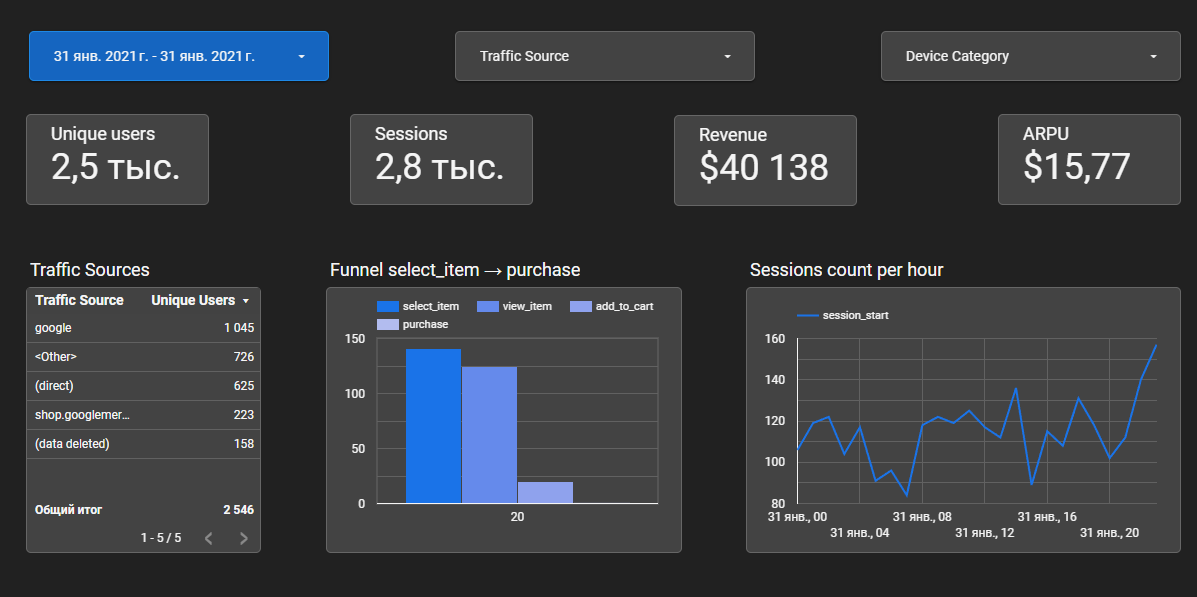